# Word2Vec

## CBOW モデル

In [1]:
import numpy as np
from abc import ABCMeta, abstractmethod


class MLPLayer(metaclass=ABCMeta):
    @abstractmethod
    def forward(self):
        pass
    
    @abstractmethod
    def backward(self):
        pass


class MatMulIn(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A_list = []
    
    def forward(self, A_list, is_training=False):
        out = np.zeros((A_list[0].shape[0], self.W.shape[1]))
        for A in A_list:
            out += np.dot(A, self.W)
        out /= len(A_list)
        if is_training:
            self.A_list = A_list
        return out
    
    def backward(self, dout):
        #dA = np.dot(dout, self.W)
        dA = np.dot(dout, self.W.T)
        self.dW = np.zeros(self.W.shape)
        for A in self.A_list:
            self.dW += np.dot(dout.T, A).T
        self.dW /= len(self.A_list)
        return dA

    
class MatMulOut(MLPLayer):
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.A = None
    
    def forward(self, A, is_training=False):
        out = np.dot(A, self.W)
        if is_training:
            self.A = A
        return out
    
    def backward(self, dout):
        #dA = np.dot(dout, self.W)
        dA = np.dot(dout, self.W.T)
        self.dW = np.dot(dout.T, self.A).T
        
        self.A = None
        return dA


class Affine(MLPLayer):
    def __init__(self, W, b):
        # モデルの重み
        self.W = W
        self.b = b
        # 重みの勾配
        self.dW = None
        self.db = None
        # Adam 用パラメータ
        self.v_W = np.zeros(W.shape)
        self.v_b = np.zeros(b.shape)
        self.h_W = np.zeros(W.shape)
        self.h_b = np.zeros(b.shape)
        # 誤差逆伝播用の中間データ
        self.A = None

    def forward(self, A, is_training=False):
        out = np.dot(A, self.W.T) + self.b
        
        if is_training:
            self.A = A
        return out

    def backward(self, dout):
        dA = np.dot(dout, self.W)
        self.dW = np.dot(dout.T, self.A)
        self.db = dout.sum(axis=0)
        
        self.A = None
        return dA


class SoftMax(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y = None
    
    def forward(self, Z, is_training=False):
        Z_exp = np.exp(Z)
        Y = (Z_exp.T / Z_exp.sum(axis=1)).T
        
        if is_training:
            self.Y = Y
        return Y
    
    def backward(self, dout):
        dZ = self.Y * (dout.T - np.sum(self.Y * dout, axis=1)).T
        
        self.Y = None
        return dZ


class CostCalculation(MLPLayer):
    def __init__(self):
        # 誤差逆伝播用の中間データ
        self.Y_predict = None
        self.Y_correct = None
    
    def forward(self, Y_predict, Y_correct, is_training=False):
        cost = - np.sum(Y_correct * np.log(Y_predict) + (1.0 - Y_correct) * np.log(1.0 - Y_predict), axis=1)
        cost = np.average(cost)
        
        if is_training:
            self.Y_predict = Y_predict
            self.Y_correct = Y_correct
        return cost
    
    def backward(self, dout=1.0):
        batch_size = self.Y_predict.shape[0]
        dA = (self.Y_predict - self.Y_correct) / (self.Y_predict * (1.0 - self.Y_predict)) / batch_size
        
        self.Y_predict = None
        self.Y_correct = None
        return dA

0 5.08761368994783
100 2.2873474098199695
200 1.9638422770270292
300 1.855970732682135
400 1.813344142754579
500 1.7911205996989479
600 1.7794971592210873
700 1.7734369246666375
800 1.7699963461606263
900 1.7678204917178715


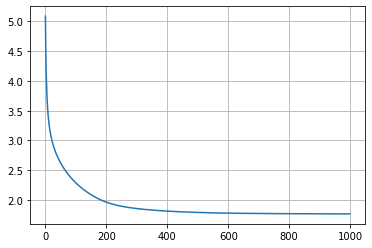

I	[ 2.44417187 -0.16361257  1.54876979 -0.09574359  1.68049699]
say	[-1.48061798 -1.2480011   1.11905655 -0.51744905 -1.9751576 ]
hello	[-0.19484317  1.16595252 -0.16848114 -1.58234769  2.42925657]
.	[-2.40291285 -0.11185574 -0.26385354 -1.24729914 -1.1322048 ]
You	[ 0.16016848  0.65640077 -0.76909549 -0.53162023 -0.17273062]
goodbye	[ 0.53985685  1.03910594  0.87179241 -1.77569526  1.03934756]
He	[ 0.02909822  0.2171231  -1.23939198 -0.90455903  1.78767673]
She	[-0.84193696  1.36511792 -0.5258273  -1.69574773  0.47889015]


In [4]:
class Word2Vec:
    def __init__(self, epochs=10, eta=0.1, n_hidden=5):
        self.word2index = {}
        self.index2word = []
        self.word_cnt = 0
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.eta = eta
        self.cost = []
        
    def fit(self, words):
        one_hot = self.words2one_hot(words)
        context_vector_list, correct_labels = self.one_hot2context_vector(one_hot)
        self.W_in = np.random.randn(self.word_cnt, self.n_hidden)
        self.W_out = np.random.randn(self.n_hidden, self.word_cnt)
        self.layers = [
            MatMulIn(self.W_in),
            MatMulOut(self.W_out),
            SoftMax()
        ]
        for t in range(self.epochs):
            # フォワードプロパゲーション
            out = context_vector_list
            for l in self.layers:
                out = l.forward(out, is_training=True)
            self.cost_layer = CostCalculation()
            cost = self.cost_layer.forward(out, correct_labels, is_training=True)
            self.cost.append(cost)
            
            # バックプロパゲーション
            dout = self.cost_layer.backward()
            for l in self.layers[::-1]:
                dout = l.backward(dout)
            
            self.__update()
            
            if t % 100 == 0:
                print(t, cost)

    def words2one_hot(self, words):
        words_index = []
        for w in words:
            if w not in self.word2index:
                self.word2index[w] = self.word_cnt
                self.index2word.append(w)
                self.word_cnt += 1
            words_index.append(self.word2index[w])
        one_hot = np.zeros((len(words), self.word_cnt))
        for i in range(len(words)):
            one_hot[i][words_index[i]] = 1.0
        return one_hot
    
    def one_hot2context_vector(self, one_hot, n_context_backward=1, n_context_forward=1):
        n_A = n_context_backward + n_context_forward
        A_list = []
        for _ in range(n_A):
            A_list.append([])
        correct_labels = one_hot[n_context_backward:-n_context_forward]
        for i in range(n_context_backward, len(one_hot)-n_context_forward):
            cnt = 0
            for j in range(i-n_context_backward, i+n_context_forward+1):
                if j != i:
                    A_list[cnt].append(one_hot[j])
                    cnt += 1
        return [np.array(A) for A in A_list], correct_labels

    def __update(self):
        for layer in self.layers:
            if isinstance(layer, MatMulIn):
                layer.W -= self.eta * layer.dW
            elif isinstance(layer, MatMulOut):
                layer.W -= self.eta * layer.dW

w2v = Word2Vec(epochs=1000, n_hidden=5)
#w2v.fit(['I', 'say', 'hello', ',', 'you', 'say', 'goodbye', '.'])
w2v.fit('I say hello . You say goodbye . He say hello . She say goodbye .'.split())


%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(range(len(w2v.cost)), w2v.cost)
plt.grid()
plt.show()


for i in range(len(w2v.index2word)):
    print('{}\t{}'.format(w2v.index2word[i], w2v.layers[0].W[i]))

## 改良版 CBOW モデル

In [33]:
import numpy as np

class Embedding:
    def __init__(self, W):
        self.W = W
        self.dW = None
        self.idx_list = []
    
    def forward(self, A_list, is_training=False):
        print('--- Embedding: forward')
        batch_size = A_list[0].shape[0]
        context_size = len(A_list)
        out = np.zeros((batch_size, self.W.shape[1]))
        idx_list = []
        for i in range(context_size):
            A = A_list[i]
            idx = np.argmax(A, axis=1)
            idx_list.append(idx)
            out += self.W[idx]
        out /= context_size
        if is_training:
            self.idx_list = idx_list
        return out
    
    def backward(self, dout):
        print('--- Embedding: backward')
        context_size = len(self.idx_list)
        self.dW = np.zeros_like(self.W)
        for idx in self.idx_list:
            for i, word_id in enumerate(idx):
                self.dW[word_id] += dout[i]
            self.dW *= context_size
        self.idx_list = []
        return None


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, neg_sample_size=3):
        """
        W : 重み
        corpus : 単語 ID の配列からなるコーパス # one-hot ベクトルから成るコーパス
        power : ネガティブサンプリングにおいて、出現頻度の小さい単語を優遇（1未満の正数、ゼロに近いほど優遇）
        neg_sample_size : 負例を何件サンプリングするか
        """
        self.W = W
        #self.power = power
        self.neg_sample_size = neg_sample_size
        
        #u, counts = np.unique(np.argmax(corpus, axis=1), return_counts=True)
        u, counts = np.unique(corpus, return_counts=True)
        #p = np.zeros(corpus.shape[1])
        p = np.zeros_like(u)
        for i in range(len(u)):
            p[u[i]] = counts[i]
        # 出現頻度の小さい単語を少し出やすくする
        p = np.power(p, power)
        p = p / np.sum(p)
        self.p = p
        
        self.sigmoid_loss_layers = [SigmoidLoss() for _ in range(neg_sample_size+1)]
        
    def forward(self, h, word_ids_answer):
        """
        h : 隠れ層のデータ
        word_ids_answer : 正解単語の id リスト
        """
        # 出力層の正解単語成分
        out_positive = self.W[:, word_ids_answer]
        # 出力層の不正解単語成分
        for neg_sample_ids in self.__select_negative_sample_ids(word_ids_answer):
            out_negative = self.W[:, neg_sample_ids]
            
        #for i, id_answer in enumerate(word_ids_answer):
        #    cost = 0
    
    def __select_negative_sample_ids(self, word_ids_answer):
        ids_candidates = np.array(set(range(self.W.shape[0])) - set(word_ids_answer))
        p_new = self.p[ids_candidates]
        return np.array([np.random.choice(ids_candidates, size=self.neg_sample_size, replace=False, p=p_new) for _ in range(self.neg_sample_size)])


class SigmoidLoss:
    def __init__(self):
        self.p_expected = None
    
    def forward(self, out_actual, p_expected):
        p_actual = 1.0 / (1.0 + np.exp(-out_actual))
        loss = - (p_expected * np.log(p_actual) + (1.0-p_expected) * np.log(1.0-p_actual))
        self.p_expected = p_expected
        return loss
    
    def backward(self, dout=1.0):
        din = self.p_expected * (1.0 - self.p_expected) * dout
        return din

    
class NegativeSamplingLossXXXXXX:
    def __init__(self, W, corpus, power=0.75, neg_sample_size=3):
        self.W = W
        self.dW = None
        self.neg_sample_size = neg_sample_size
        u, counts = np.unique(np.argmax(corpus, axis=1), return_counts=True)
        p = np.zeros(corpus.shape[1])
        for i in range(len(u)):
            p[u[i]] = counts[i]
        p = np.power(p, power)
        p = p / np.sum(p)
        self.p = p
        self.loss_layers = [SigmoidLoss() for _ in range(neg_sample_size+1)]
    
    def forward(self, H, answers):
        """
        H : 隠れ層の出力
        answers : 正解単語のインデックスの配列
        """
        loss = 0
        for i in range(len(answers)):
            dot = H[i].dot(W[:, answers[i]])
            p = self.sigmoid(dot)
            loss += self.loss_layers[0].forward(p, 1.0)
            words = np.random.choice(range(W.shape[1]), size=self.neg_sample_size, replace=False, p=self.p)
            for j in range(len(words)):
                dot = H[i].dot(W[:, words[j]])
                p = self.sigmoid(dot)
                loss += self.loss_layers[1+j].forward(p, 0.)
        return loss
    
    def backward(self, dout):
        pass
    
    def sigmoid(self, num):
        return 1.0 / (1.0 + np.exp(-num))

In [34]:
A_list = [
    np.array([
        [0,1,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1,0,0,0]
    ]),
    np.array([
        [0,0,0,1,0,0,0,0,0,0],
        [1,0,0,0,0,0,0,0,0,0],
        [0,1,0,0,0,0,0,0,0,0]
    ])
]
W = np.array(
    [
        [0,0,0,0,0.1],
        [0,0,0,0,0.2],
        [0,0,0,0,0.3],
        [0,0,0,0,0.4],
        [0,0,0,0,0.5],
        [0,0,0,0,0.6],
        [0,0,0,0,0.7],
        [0,0,0,0,0.8],
        [0,0,0,0,0.9],
        [0,0,0,0,1.0]
    ]
)

e = Embedding(W)
e_out = e.forward(A_list, True)
e_dout = e_out * 0.1
e.backward(e_dout)
print(e_dout)
print(e.dW)

--- Embedding: forward
[1 9 6]
[[0.  0.  0.  0.  0.2]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.7]]
[3 0 1]
[[0.  0.  0.  0.  0.4]
 [0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.2]]
--- Embedding: backward
[1 9 6]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[3 0 1]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.06]]
[[0.    0.    0.    0.    0.03 ]
 [0.    0.    0.    0.    0.055]
 [0.    0.    0.    0.    0.045]]
[[0.   0.   0.   0.   0.11]
 [0.   0.   0.   0.   0.21]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.06]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.18]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.22]]
